In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LayerNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras.callbacks import EarlyStopping

In [110]:
df = pd.read_csv("500034_1.csv")

In [111]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [112]:
df['change_close'] = (df['Close Price'] - df['Close Price'].shift(-1)) / df['Close Price'].shift(-1) * 100
df['change_open'] = (df['Open Price'] - df['Open Price'].shift(-1)) / df['Open Price'].shift(-1) * 100

In [113]:
df.dropna(axis= 0, inplace=True)

In [114]:
df.head()

,Open Price,High Price,Low Price,Close Price,WAP,No.of Shares,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open,change_close,change_open
Date,,,,,,,,,,,,,,
2024-04-30,6836.80,6972.40,6821.65,6931.05,6902.035176,104673,15883,7.224567e+08,56404.0,53.89,150.75,94.25,1.518147,-0.034361
2024-04-29,6839.15,6839.15,6710.45,6827.40,6778.717558,43786,6113,2.968129e+08,13921.0,31.79,128.70,-11.75,1.449512,-2.417744
2024-04-26,7008.60,7008.60,6691.40,6729.85,6771.995278,357244,30558,2.419255e+09,191023.0,53.47,317.20,-278.75,-7.733174,-4.384720
2024-04-25,7330.00,7362.95,7129.35,7293.90,7260.067915,27181,4150,1.973359e+08,7059.0,25.97,233.60,-36.10,-0.461263,0.605969
2024-04-24,7285.85,7417.00,7250.05,7327.70,7334.994097,17956,2405,1.317072e+08,7339.0,40.87,166.95,41.85,0.942935,-0.193836


In [115]:
df['change_close'] = df['change_close'].clip(upper = df['change_close'].quantile(0.999), lower = df['change_close'].quantile(0.001))
df['change_open'] = df['change_open'].clip(upper = df['change_open'].quantile(0.999), lower = df['change_open'].quantile(0.001))

<Axes: xlabel='change_open'>

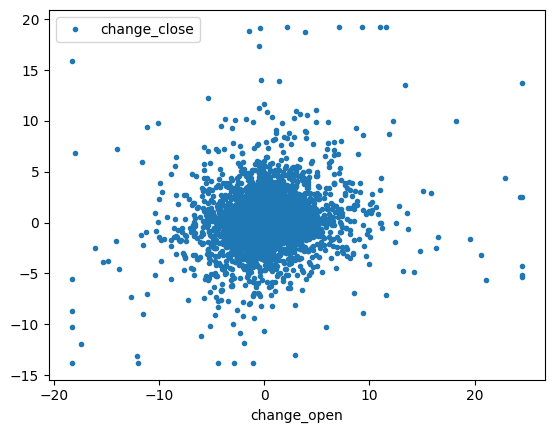

In [116]:
df.plot(x = 'change_open', y = 'change_close', style = '.',)

In [117]:
df.corr().loc['change_close', 'change_open']
print(np.corrcoef(df['change_close'].iloc[:-1:1], df['change_close'].shift(-1).iloc[:-1:1])[0,1])

0.03232368417028862


In [118]:
for i in range(2, 21):
  df[f'change_close_prev_{i}'] = df['change_close'].rolling(i).mean().shift(-i+1)
  df[f'change_open_prev_{i}'] = df['change_open'].rolling(i).mean().shift(-i+1)

In [119]:
print(df.shape)
df.dropna(axis = 0, inplace = True)
print(df.shape)

(4455, 52)
(4436, 52)


In [120]:
for i in range(2,21):
  #plt.figure()
  #plt.scatter(x = df[f'change_close_prev_{i}'].shift(-1), y = df['change_close'])
  print("-----------------------------------------------------------------")
  print(np.corrcoef(df['change_close'].iloc[:-1:1], df[f'change_close_prev_{i}'].shift(-1).iloc[:-1:1])[0,1])
  print(np.corrcoef(df['change_open'].iloc[:-1:1], df[f'change_open_prev_{i}'].shift(-1).iloc[:-1:1])[0,1])
  print(np.corrcoef(df['change_close'].iloc[:-1:1], df[f'change_open_prev_{i}'].shift(-1).iloc[:-1:1])[0,1])

-----------------------------------------------------------------
0.029464200879463134
-0.0966826149256564
-0.003523163542933076
-----------------------------------------------------------------
0.01438080664474388
-0.10694431091712349
0.005517220916146104
-----------------------------------------------------------------
0.017005425563720995
-0.07103696354707263
-0.011898936571002485
-----------------------------------------------------------------
0.010641252661893842
-0.06940791286462576
-0.009907716881409599
-----------------------------------------------------------------
0.0045597988284704445
-0.06965958886508548
-0.010321677972495877
-----------------------------------------------------------------
0.01001665859671761
-0.08387045371258192
0.007277061834108107
-----------------------------------------------------------------
0.018553108023038327
-0.053684315191605436
0.020005958104013375
-----------------------------------------------------------------
0.02286330172997882
-0.03879

In [121]:
#df['Open Price'] = df['Open Price'].shift(1)
#df['High Price'] = df['High Price'].shift(1)
#df['Low Price'] = df['Low Price'].shift(1)
df.sort_index(inplace = True)
interest = df[['change_close', 'change_open']].values.reshape(-1,1) #keep y at the first index

In [122]:
n_steps = 50
n_features = 2
buffer = 0

X = []
y = []

scaler = MinMaxScaler(feature_range=(0,1)) #

interest = scaler.fit_transform(interest)


for j in range(len(interest)-(n_steps + buffer)):
    X.append(interest[j:j+(n_steps)])
    y.append(interest[j+(n_steps + buffer)][0])

In [123]:
X,y = np.array(X), np.array(y)

In [124]:
print(X.shape, y.shape)

(8822, 50, 1) (8822,)


In [125]:
pd.qcut(y, 100)

[(0.3711, 0.3749], (0.5882, 0.6392], (0.4265, 0.4274], (0.3133, 0.3266], (0.5135, 0.5204], ..., (0.3133, 0.3266], (0.4602, 0.4621], (0.3672, 0.3711], (0.4621, 0.4639], (0.4265, 0.4274]]
Length: 8822
Categories (100, interval[float64, right]): [(-0.0001, 0.2512] < (0.2512, 0.294] < (0.294, 0.3133] <
                                             (0.3133, 0.3266] ... (0.5422, 0.5578] <
                                             (0.5578, 0.5882] < (0.5882, 0.6392] < (0.6392, 1.0]]

In [126]:
X_new = X
y_new = y

In [127]:
length = X.shape[0]
ratio = 0.92
x_train, x_test = X_new[:int(length * ratio)], X_new[int(length * ratio):]
y_train, y_test = y[:int(length * ratio)], y[int(length * ratio):]

In [129]:
x_test.shape

(706, 50, 1)

In [130]:
x_train.shape

(8116, 50, 1)

In [22]:
y.shape[0]

8822

In [23]:
X.shape

(8822, 50, 1)

In [107]:
df['change%'] = (df['Close Price'] - df['Close Price'].shift(-1)) / df['Close Price'].shift(-1) * 100

<Axes: xlabel='Date'>

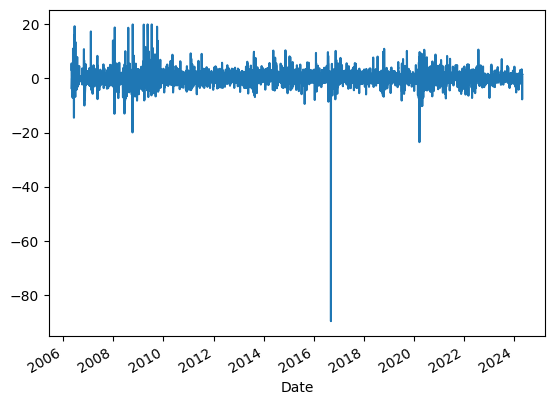

In [ ]:
df['change%'].plot()

In [30]:
df['chage_1'] = df['change%'].shift(1)
df['chage_2'] = df['change%'].shift(2)
df['chage_3'] = df['change%'].shift(3)

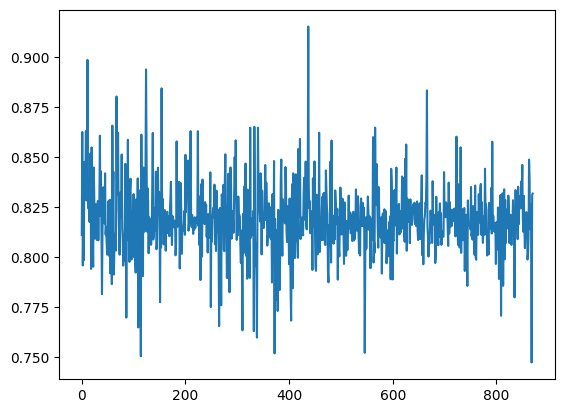

In [ ]:
plt.plot(y_test)

In [31]:
X.shape

(8822, 50, 1)

In [40]:
df['change%']

,change%
Date,
2006-05-30,7.693175
2006-05-31,4.183805
2006-06-01,-0.093930
2006-06-02,2.000000
2006-06-05,5.522558
...,...
2024-04-24,0.463401
2024-04-25,8.381316
2024-04-26,-1.428802


In [131]:
X_new = X_new.reshape(X_new.shape[0],-1)

In [135]:
y_new = y_new.reshape(-1,)

In [136]:
y_new.shape

(8822,)

In [137]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import ElasticNetCV as ENC
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.neural_network import MLPRegressor as MLP

print(LR().fit(X = X_new, y=y_new).score(X_new, y_new))
print(ENC(max_iter = 10000).fit(X = X_new, y=y_new).score(X_new, y_new))
print(RFR().fit(X = X_new, y=y_new).score(X_new, y_new))
print(MLP(hidden_layer_sizes=(50, 1000, 100, 1), activation='relu', solver='adam', max_iter=1000).fit(X = X_new, y=y_new).score(X_new, y_new))

0.2409337773029373
0.24009426082994134
0.8914981469246616
-0.0025115484265034738


In [138]:
print(ENC(max_iter = 10000).fit(X = X_new, y=y_new).score(X_new, y_new))

0.24009426082994134


In [ ]:
print(MLP(hidden_layer_sizes=(50,10000,10000,50,10,10,10,5,5,5,), activation='relu', solver='adam', max_iter=10000).fit(X = X_new, y=y_new).score(X_new, y_new))

In [ ]:
print(RFR().fit(X = X_new, y=y_new).score(X_new, y_new))

In [ ]:
print(x_train.shape, y_train.shape)

(4052, 50) (4052,)


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor as GBR
print(GBR().fit(X = x_train, y=y_train).score(x_test, y_test))

In [ ]:
print(RFR(n_estimators = 1000).fit(X = x_train, y=y_train).score(x_test, y_test))